### Data Dictionary


    male: 1 if the parolee is male, 0 if female
    race: 1 if the parolee is white, 2 otherwise
    age: the parolee's age (in years) when he or she was released from prison
    state: a code for the parolee's state. 2 is Kentucky, 3 is Louisiana, 4 is Virginia, and 1 is any other state. The three states were selected due to having a high representation in the dataset.
    time.served: the number of months the parolee served in prison (limited by the inclusion criteria to not exceed 6 months).
    max.sentence: the maximum sentence length for all charges, in months (limited by the inclusion criteria to not exceed 18 months).
    multiple.offenses: 1 if the parolee was incarcerated for multiple offenses, 0 otherwise.
    crime: a code for the parolee's main crime leading to incarceration. 2 is larceny, 3 is drug-related crime, 4 is driving-related crime, and 1 is any other crime.
    violator: 1 if the parolee violated the parole, and 0 if the parolee completed the parole without violation.



In this problem, we will build and validate a model that predicts if an inmate will violate the terms of his or her parole. Such a model could be useful to a parole board when deciding to approve or deny an application for parole.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score

import keras
from keras.models import save_model, Sequential
from keras.layers import Activation, BatchNormalization, Dense
from keras.optimizers import Adam

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.


### Data Exploration

In [2]:
df = pd.read_csv("parole.csv")

In [3]:
df

,male,race,age,state,timeserved,maxsentence,multipleoffenses,crime,violator
0,1,1,33.2,1,5.5,18,0,4,0
1,0,1,39.7,1,5.4,12,0,3,0
2,1,2,29.5,1,5.6,12,0,3,0
3,1,1,22.4,1,5.7,18,0,1,0
4,1,2,21.6,1,5.4,12,0,1,0
...,...,...,...,...,...,...,...,...,...
670,1,1,47.1,4,4.2,16,1,1,0
671,0,1,47.5,1,5.2,16,0,3,0
672,1,1,45.4,1,5.7,12,0,3,0
673,1,1,38.4,1,1.8,18,0,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   male              675 non-null    int64  
 1   race              675 non-null    int64  
 2   age               675 non-null    float64
 3   state             675 non-null    int64  
 4   timeserved        675 non-null    float64
 5   maxsentence       675 non-null    int64  
 6   multipleoffenses  675 non-null    int64  
 7   crime             675 non-null    int64  
 8   violator          675 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 47.6 KB


In [5]:
df.describe(include='all')

,male,race,age,state,timeserved,maxsentence,multipleoffenses,crime,violator
count,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000
mean,0.807407,1.423704,34.512296,2.887407,4.198074,13.056296,0.536296,2.059259,0.115556
std,0.394628,0.494511,10.351541,1.226224,1.226855,3.056797,0.499051,1.135892,0.319928
min,0.000000,1.000000,18.400000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,1.000000,1.000000,25.350000,2.000000,3.250000,12.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,33.700000,3.000000,4.400000,12.000000,1.000000,2.000000,0.000000
75%,1.000000,2.000000,42.550000,4.000000,5.200000,15.000000,1.000000,3.000000,0.000000
max,1.000000,2.000000,67.000000,4.000000,6.000000,18.000000,1.000000,4.000000,1.000000


In [6]:
df.shape

(675, 9)

In [7]:
df.columns

Index(['male', 'race', 'age', 'state', 'timeserved', 'maxsentence',
       'multipleoffenses', 'crime', 'violator'],
      dtype='object')

### Data Visualization

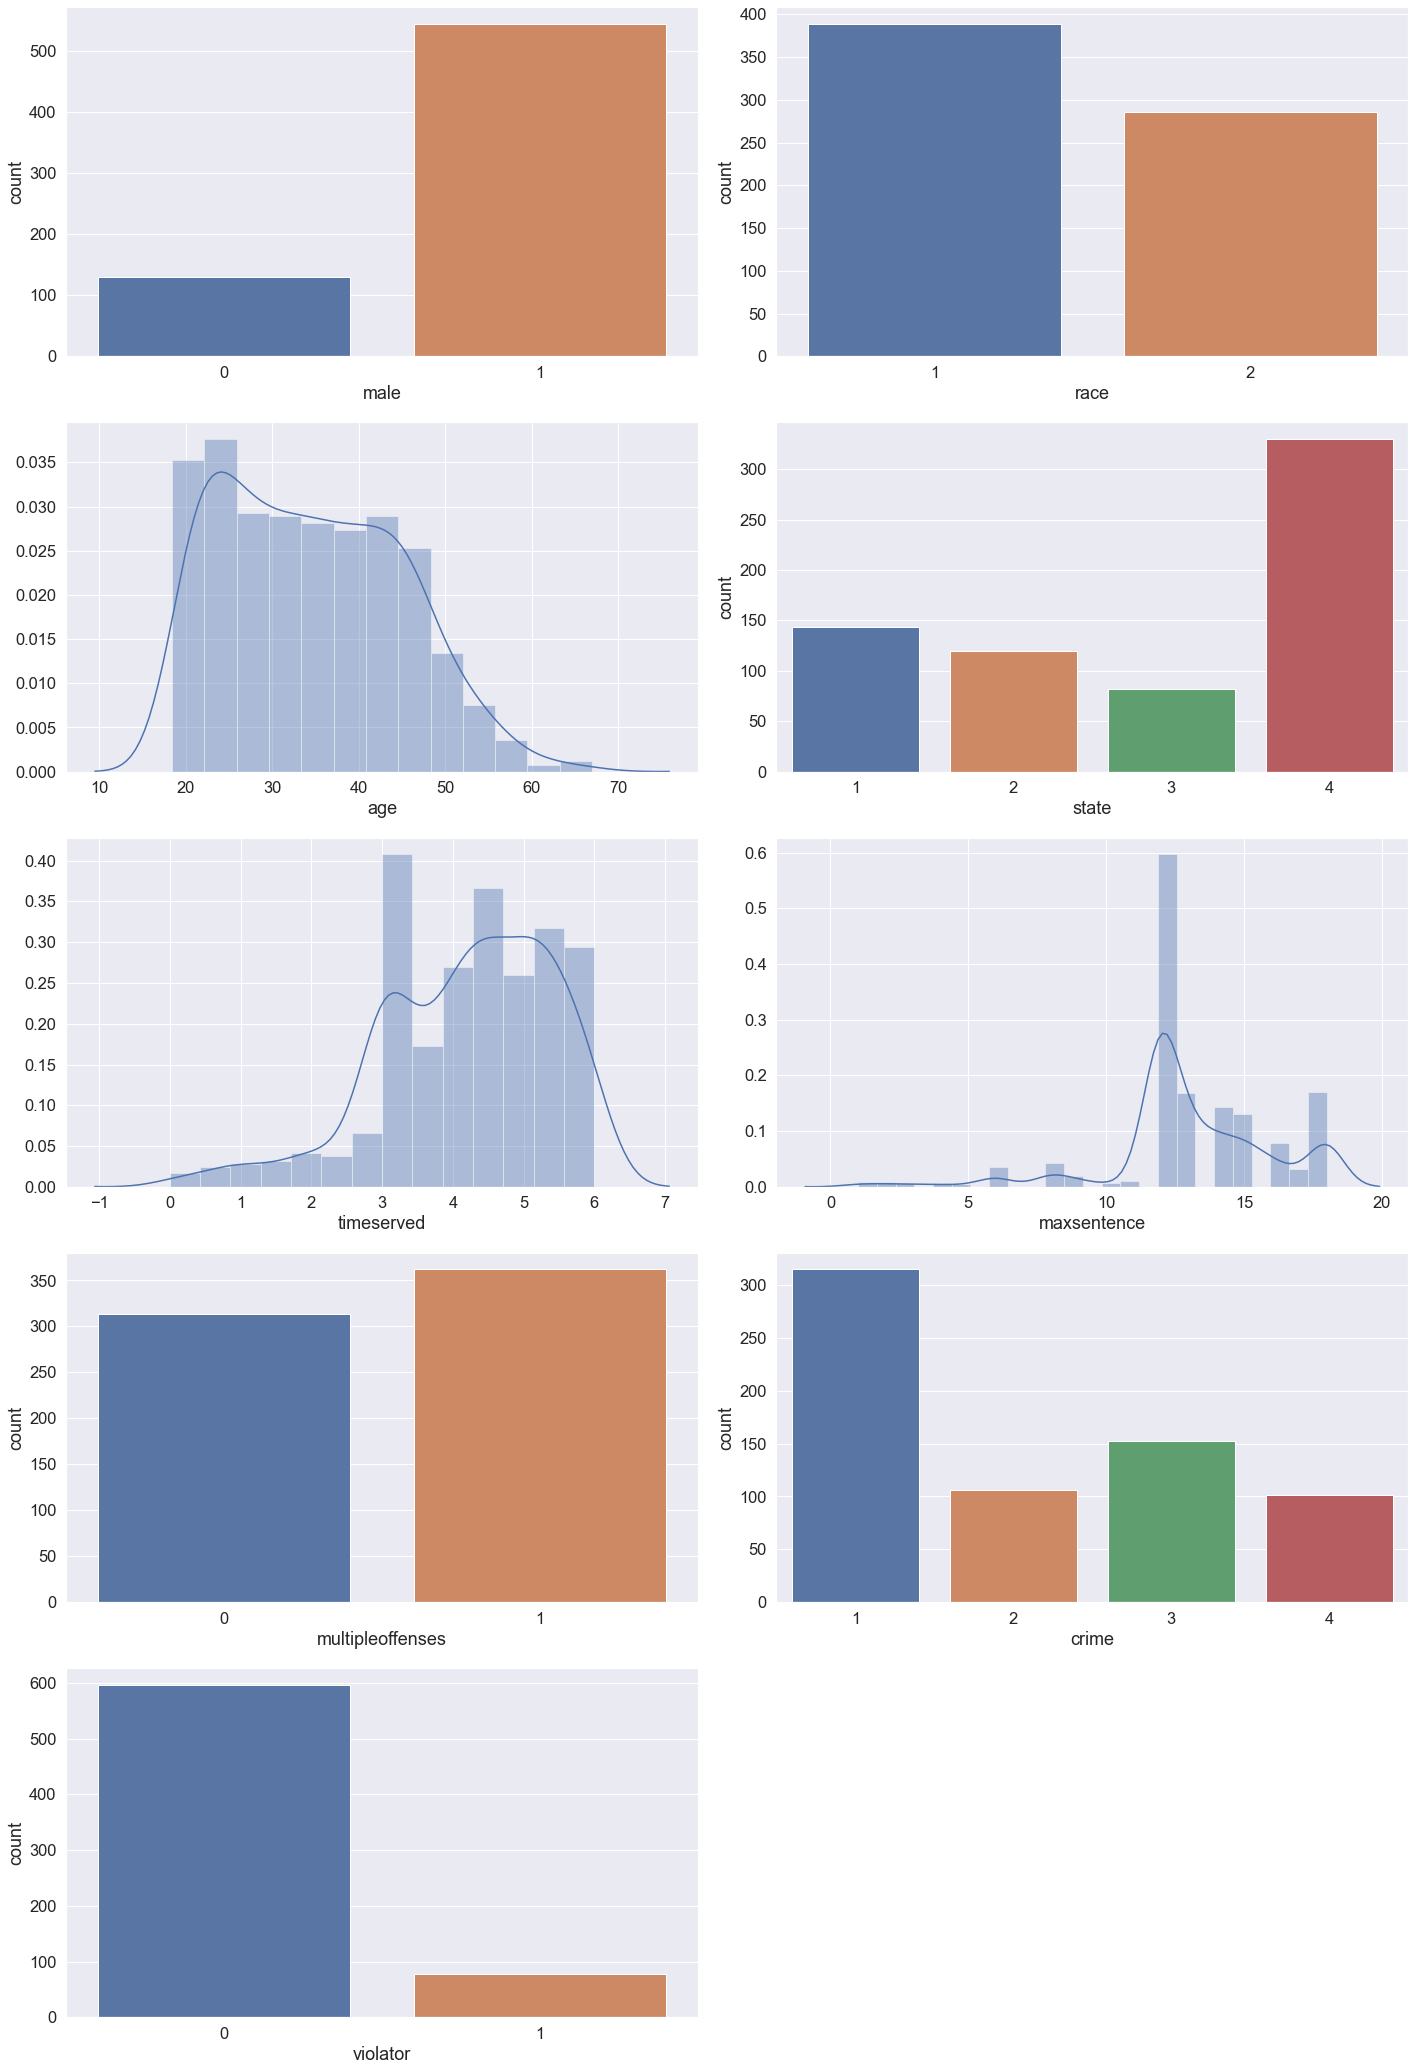

In [8]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.countplot(df.male)

plt.subplot(7,2,2)
sns.countplot(df.race)
plt.subplot(7,2,3)
sns.distplot(df.age)

plt.subplot(7,2,4)
sns.countplot(df.state)
plt.subplot(7,2,5)
sns.distplot(df.timeserved)
plt.subplot(7,2,6)
sns.distplot(df.maxsentence)
plt.subplot(7,2,7)
sns.countplot(df.multipleoffenses)
plt.subplot(7,2,8)
sns.countplot(df.crime)
plt.subplot(7,2,9)
sns.countplot(df.violator)
# plt.subplot(7,2,10)
# sns.countplot(df.Playoffs)
# plt.subplot(7,2,11)
# sns.countplot(df.RankSeason)
# plt.subplot(7,2,12)
# sns.countplot(df.RankPlayoffs)
# plt.subplot(7,2,13)
# sns.countplot(df.G)
# plt.subplot(7,2,14)
# sns.distplot(df.OOBP)

plt.tight_layout()
plt.show()

In [9]:
df.corr()

,male,race,age,state,timeserved,maxsentence,multipleoffenses,crime,violator
male,1.000000,0.000619,-0.056624,0.037906,-0.066347,0.065579,0.035548,-0.010910,0.012013
race,0.000619,1.000000,-0.033568,0.396871,-0.085713,-0.001080,0.190095,-0.110800,0.074566
age,-0.056624,-0.033568,1.000000,-0.092757,0.078117,0.040059,-0.115241,0.111887,-0.004462
state,0.037906,0.396871,-0.092757,1.000000,-0.146402,0.127170,0.503715,-0.118766,-0.144538
timeserved,-0.066347,-0.085713,0.078117,-0.146402,1.000000,0.149060,-0.153158,0.014561,-0.098469
maxsentence,0.065579,-0.001080,0.040059,0.127170,0.149060,1.000000,0.003521,0.072534,-0.168994
multipleoffenses,0.035548,0.190095,-0.115241,0.503715,-0.153158,0.003521,1.000000,-0.118962,0.103789
crime,-0.010910,-0.110800,0.111887,-0.118766,0.014561,0.072534,-0.118962,1.000000,-0.043368
violator,0.012013,0.074566,-0.004462,-0.144538,-0.098469,-0.168994,0.103789,-0.043368,1.000000


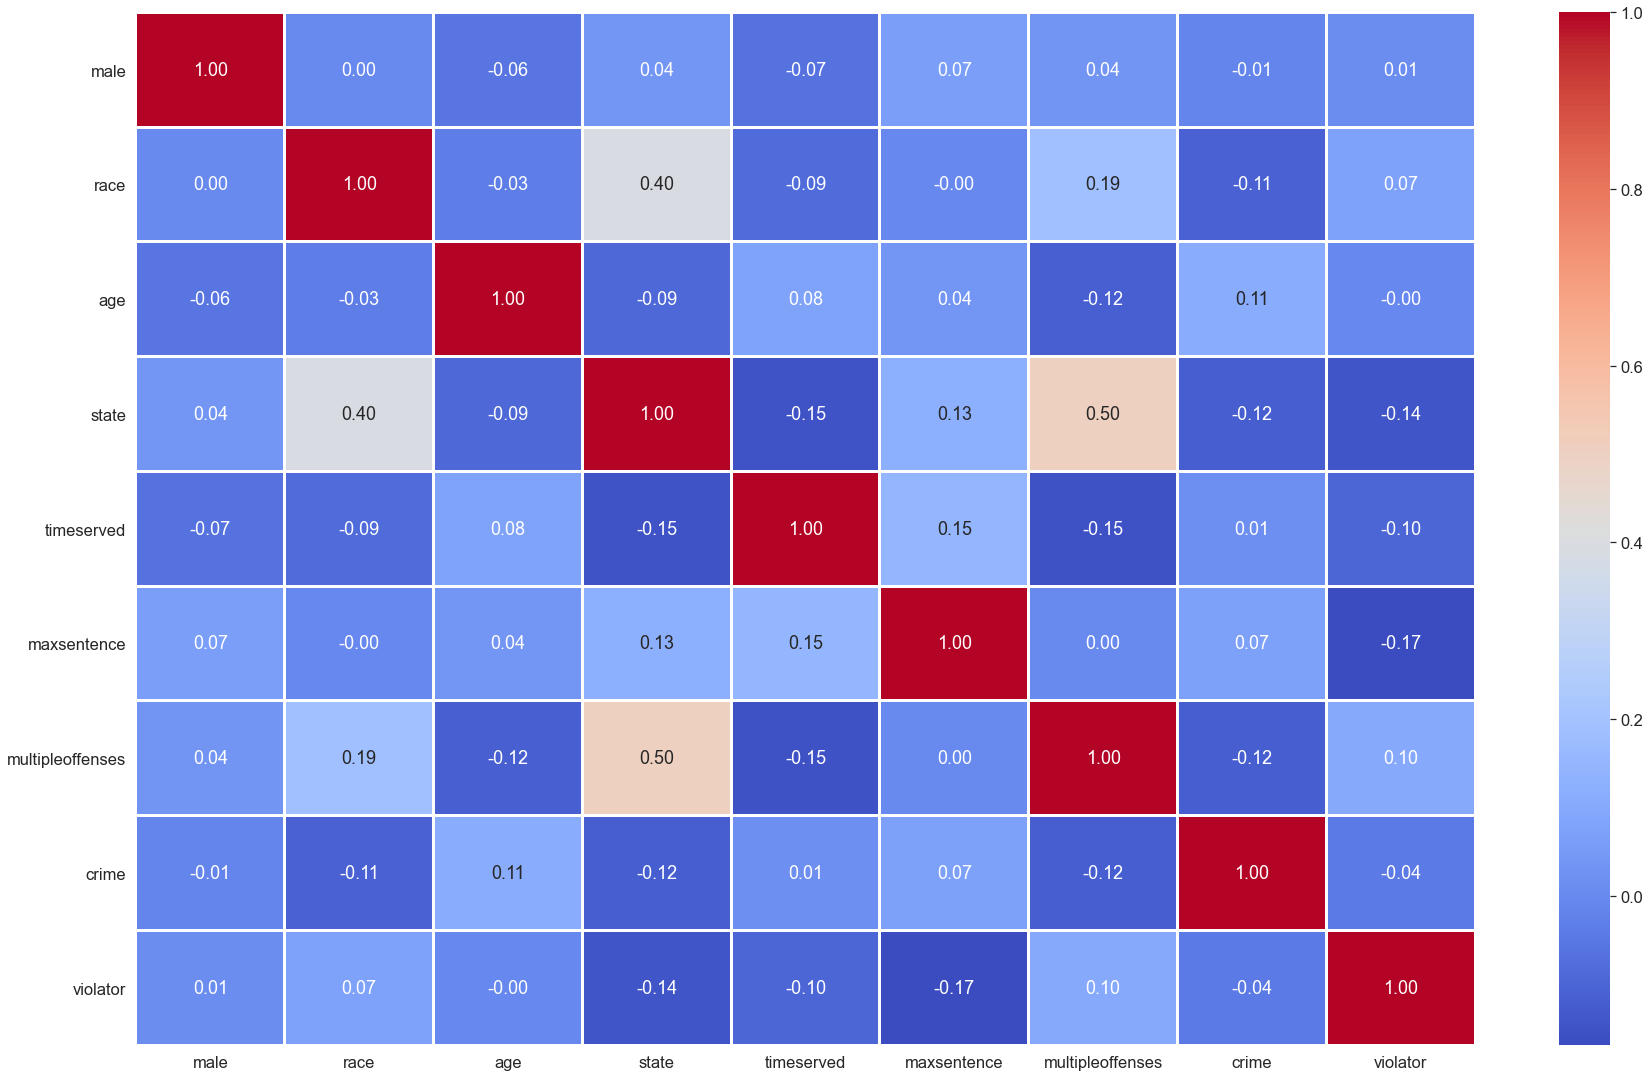

In [10]:
plt.figure(figsize=(30,19))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

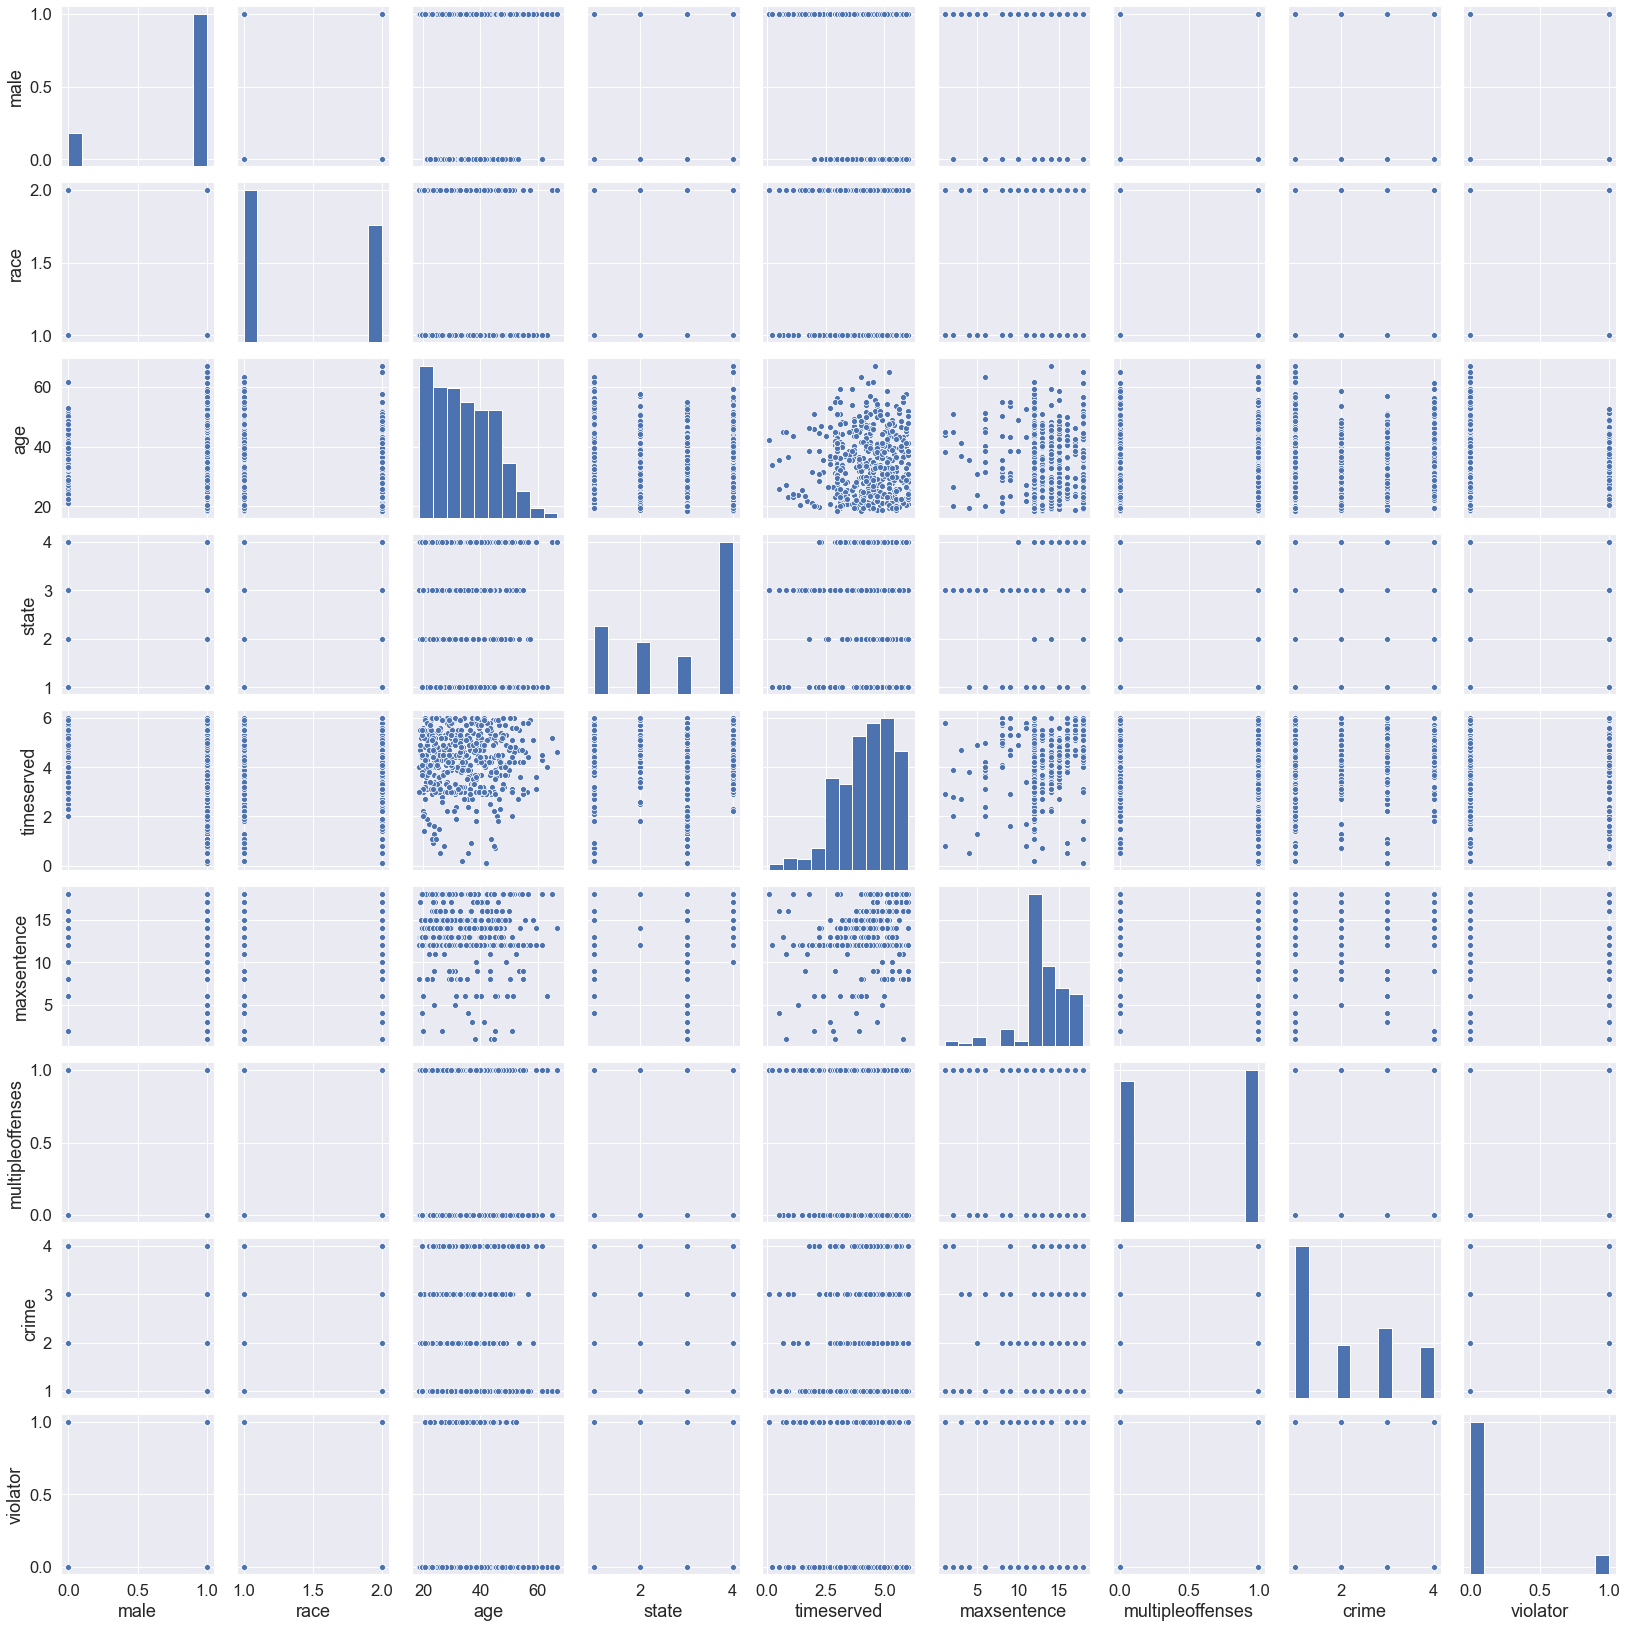

In [11]:
sns.pairplot(df.sample(500))
plt.show()

### Data Preprocessing

### Treat Missing Values

In [12]:
df.isnull().sum()

male                0
race                0
age                 0
state               0
timeserved          0
maxsentence         0
multipleoffenses    0
crime               0
violator            0
dtype: int64

### Treat Duplicate Values

In [13]:
df.duplicated(keep='first').sum()

20

In [14]:
df[df.duplicated(keep=False)]

,male,race,age,state,timeserved,maxsentence,multipleoffenses,crime,violator
67,1,2,57.5,2,5.9,12,0,1,0
68,1,2,57.5,2,5.9,12,0,1,0
75,0,1,33.2,2,4.8,12,0,1,0
76,0,1,33.2,2,4.8,12,0,1,0
78,0,1,43.6,2,3.8,12,0,3,0
79,0,1,43.6,2,3.8,12,0,3,0
127,1,2,23.3,2,5.2,12,0,3,0
128,1,2,23.3,2,5.2,12,0,3,0
136,0,1,36.2,2,5.1,12,1,2,0
137,0,1,36.2,2,5.1,12,1,2,0


In [15]:
df.drop_duplicates(inplace=True, ignore_index=True)

In [16]:
df

,male,race,age,state,timeserved,maxsentence,multipleoffenses,crime,violator
0,1,1,33.2,1,5.5,18,0,4,0
1,0,1,39.7,1,5.4,12,0,3,0
2,1,2,29.5,1,5.6,12,0,3,0
3,1,1,22.4,1,5.7,18,0,1,0
4,1,2,21.6,1,5.4,12,0,1,0
...,...,...,...,...,...,...,...,...,...
650,1,1,47.1,4,4.2,16,1,1,0
651,0,1,47.5,1,5.2,16,0,3,0
652,1,1,45.4,1,5.7,12,0,3,0
653,1,1,38.4,1,1.8,18,0,1,0


### Treat Imbalance Data

In [17]:
df['violator'].value_counts()

0    577
1     78
Name: violator, dtype: int64

### Treat Outliers

In [18]:
df.describe()

,male,race,age,state,timeserved,maxsentence,multipleoffenses,crime,violator
count,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000
mean,0.809160,1.432061,34.370076,2.914504,4.170229,13.088550,0.549618,2.051908,0.119084
std,0.393263,0.495741,10.300267,1.234824,1.230368,3.097514,0.497912,1.138857,0.324135
min,0.000000,1.000000,18.400000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,1.000000,1.000000,25.300000,2.000000,3.200000,12.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,33.600000,4.000000,4.300000,13.000000,1.000000,2.000000,0.000000
75%,1.000000,2.000000,42.400000,4.000000,5.200000,15.000000,1.000000,3.000000,0.000000
max,1.000000,2.000000,67.000000,4.000000,6.000000,18.000000,1.000000,4.000000,1.000000


### Treat Data Types

### Feature Scaling

In [19]:
df.columns

Index(['male', 'race', 'age', 'state', 'timeserved', 'maxsentence',
       'multipleoffenses', 'crime', 'violator'],
      dtype='object')

In [20]:
df_cat = df[['race','state','crime']]

In [21]:
df_cat

,race,state,crime
0,1,1,4
1,1,1,3
2,2,1,3
3,1,1,1
4,2,1,1
...,...,...,...
650,1,4,1
651,1,1,3
652,1,1,3
653,1,1,1


In [22]:
df_cat = df_cat.astype("object")

In [23]:
df_cat.dtypes

race     object
state    object
crime    object
dtype: object

In [24]:
dfcategory = pd.get_dummies(df_cat,drop_first=True)

In [25]:
dfcategory

,race_2,state_2,state_3,state_4,crime_2,crime_3,crime_4
0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0
2,1,0,0,0,0,1,0
3,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
650,0,0,0,1,0,0,0
651,0,0,0,0,0,1,0
652,0,0,0,0,0,1,0
653,0,0,0,0,0,0,0


In [26]:
df.drop(['race','state','crime'],axis=1,inplace=True)

In [27]:
df

,male,age,timeserved,maxsentence,multipleoffenses,violator
0,1,33.2,5.5,18,0,0
1,0,39.7,5.4,12,0,0
2,1,29.5,5.6,12,0,0
3,1,22.4,5.7,18,0,0
4,1,21.6,5.4,12,0,0
...,...,...,...,...,...,...
650,1,47.1,4.2,16,1,0
651,0,47.5,5.2,16,0,0
652,1,45.4,5.7,12,0,0
653,1,38.4,1.8,18,0,0


In [28]:
df2 = pd.concat([dfcategory,df],axis=1)

In [29]:
df2

,race_2,state_2,state_3,state_4,crime_2,crime_3,crime_4,male,age,timeserved,maxsentence,multipleoffenses,violator
0,0,0,0,0,0,0,1,1,33.2,5.5,18,0,0
1,0,0,0,0,0,1,0,0,39.7,5.4,12,0,0
2,1,0,0,0,0,1,0,1,29.5,5.6,12,0,0
3,0,0,0,0,0,0,0,1,22.4,5.7,18,0,0
4,1,0,0,0,0,0,0,1,21.6,5.4,12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,0,0,0,1,0,0,0,1,47.1,4.2,16,1,0
651,0,0,0,0,0,1,0,0,47.5,5.2,16,0,0
652,0,0,0,0,0,1,0,1,45.4,5.7,12,0,0
653,0,0,0,0,0,0,0,1,38.4,1.8,18,0,0


In [30]:
#Save to csv
#df2.to_csv("paroletrain.csv",index=False)

### Create and save processed dataset

### Model Training

In [31]:
#df2 = pd.read_csv("paroletrain.csv")

In [32]:
df2.shape

(655, 13)

In [33]:
X = df2.iloc[:,0:12]
y = df2.iloc[:,12]

In [34]:
X.values, y.values

(array([[ 0. ,  0. ,  0. , ...,  5.5, 18. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  5.4, 12. ,  0. ],
        [ 1. ,  0. ,  0. , ...,  5.6, 12. ,  0. ],
        ...,
        [ 0. ,  0. ,  0. , ...,  5.7, 12. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  1.8, 18. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  6. , 12. ,  0. ]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 0,

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((524, 12), (131, 12), (524,), (131,))

In [37]:
xgb = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [38]:
xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='error',early_stopping_rounds=20)

[0]	validation_0-error:0.10687
Will train until validation_0-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.10687
[2]	validation_0-error:0.10687
[3]	validation_0-error:0.10687
[4]	validation_0-error:0.099237
[5]	validation_0-error:0.099237
[6]	validation_0-error:0.099237
[7]	validation_0-error:0.099237
[8]	validation_0-error:0.099237
[9]	validation_0-error:0.099237
[10]	validation_0-error:0.099237
[11]	validation_0-error:0.099237
[12]	validation_0-error:0.099237
[13]	validation_0-error:0.099237
[14]	validation_0-error:0.099237
[15]	validation_0-error:0.099237
[16]	validation_0-error:0.099237
[17]	validation_0-error:0.099237
[18]	validation_0-error:0.099237
[19]	validation_0-error:0.099237
[20]	validation_0-error:0.099237
[21]	validation_0-error:0.099237
[22]	validation_0-error:0.10687
[23]	validation_0-error:0.10687
[24]	validation_0-error:0.10687
Stopping. Best iteration:
[4]	validation_0-error:0.099237



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [39]:
y_pred = xgb.predict(X_test)

In [40]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
      dtype=int64)

### Model Evaluation

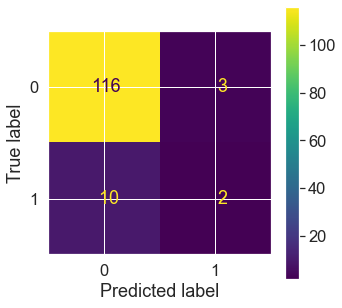

In [41]:
fig , ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(xgb,X_test,y_test,values_format='4g',ax=ax)
plt.show()

In [42]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       119
           1       0.40      0.17      0.24        12

    accuracy                           0.90       131
   macro avg       0.66      0.57      0.59       131
weighted avg       0.87      0.90      0.88       131



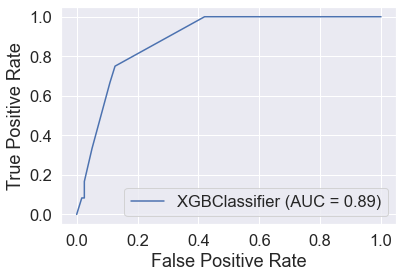

In [43]:
plot_roc_curve(xgb,X_test,y_test)
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

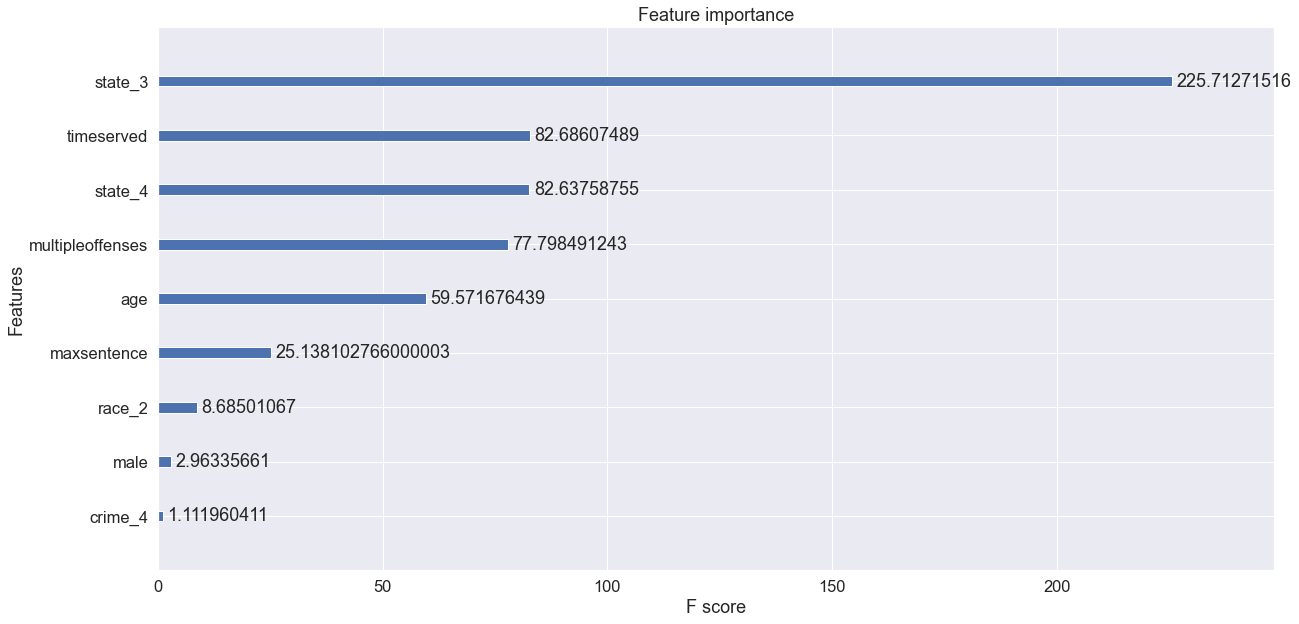

In [44]:
fig, ax = plt.subplots(figsize=(20,10))
plot_importance(xgb,ax=ax,importance_type='total_gain')
plt.show()

Example:

f = 'gain'

XGBClassifier.get_booster().get_score(importance_type= f)

### Cross-Validation

In [45]:
cv = cross_val_score(xgb,X,y,cv=5,verbose=1,scoring='accuracy')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


In [46]:
cv.mean()

0.8030534351145038

### Model Tuning

In [47]:
model = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [48]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [49]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, n_jobs=-1,
                           scoring='accuracy')

In [50]:
randm.fit(X, y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
       34, 36, 38, 40, 42, 44, 46, 48]),
                                        'learning rate': array([0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29]),
                

In [51]:
randm.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=40,
              learning rate=0.16999999999999998, learning_rate=0.1,
              max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
              n_estimators=200, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.6, verbosity=1)

In [52]:
randm.best_score_

0.8809160305343511

In [53]:
randm.best_params_

{'subsample': 0.6,
 'n_estimators': 200,
 'min_child_weight': 1,
 'max_depth': 8,
 'learning rate': 0.16999999999999998,
 'gamma': 40,
 'colsample_bytree': 0.7}

### Final Model

In [54]:
xgbnew = XGBClassifier(random_state=0, n_estimators=600, objective='binary:logistic',max_depth=5,
                      gamma=42, min_child_weight=2,subsample=0.7,learning_rate=0.08,colsample_bytree=0.7)

In [55]:
xgbnew.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='error',early_stopping_rounds=30)

[0]	validation_0-error:0.091603
Will train until validation_0-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.091603
[2]	validation_0-error:0.091603
[3]	validation_0-error:0.091603
[4]	validation_0-error:0.091603
[5]	validation_0-error:0.091603
[6]	validation_0-error:0.091603
[7]	validation_0-error:0.091603
[8]	validation_0-error:0.091603
[9]	validation_0-error:0.091603
[10]	validation_0-error:0.091603
[11]	validation_0-error:0.091603
[12]	validation_0-error:0.091603
[13]	validation_0-error:0.091603
[14]	validation_0-error:0.091603
[15]	validation_0-error:0.091603
[16]	validation_0-error:0.091603
[17]	validation_0-error:0.091603
[18]	validation_0-error:0.091603
[19]	validation_0-error:0.091603
[20]	validation_0-error:0.091603
[21]	validation_0-error:0.091603
[22]	validation_0-error:0.091603
[23]	validation_0-error:0.091603
[24]	validation_0-error:0.091603
[25]	validation_0-error:0.091603
[26]	validation_0-error:0.091603
[27]	validation_0-error:0.091603
[28]	validation_0-er

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=42,
              learning_rate=0.08, max_delta_step=0, max_depth=5,
              min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

In [56]:
y_pred = xgbnew.predict(X_test)

In [57]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

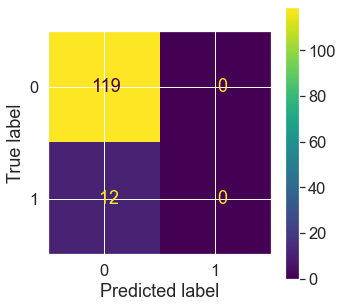

In [58]:
fig , ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(xgbnew,X_test,y_test,values_format='4g',ax=ax)
plt.show()

In [59]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       119
           1       0.00      0.00      0.00        12

    accuracy                           0.91       131
   macro avg       0.45      0.50      0.48       131
weighted avg       0.83      0.91      0.86       131



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


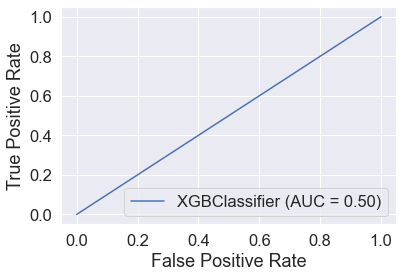

In [60]:
plot_roc_curve(xgbnew,X_test,y_test)
plt.show()